In [1]:
en_dir="/home/apsisdev/ansary/DATASETS/EnNums/"
bn_dir="/home/apsisdev/ansary/DATASETS/BnNums/"
save_dir="/home/apsisdev/ansary/DATASETS/APSIS/CDR/datasets/numbers/"

In [2]:
import os 
import numpy as np
import cv2
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot  as plt
tqdm.pandas()
import random
from coreLib.processing import correctPadding
from coreLib.utils import create_dir
en_vocab=["0","1","2","3","4","5","6","7","8","9"]
bn_vocab=['০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯']

def random_exec(poplutation=[0,1],weights=[0.5,0.5],match=0):
    return random.choices(population=poplutation,weights=weights,k=1)[0]==match

def get_df_dict(_dir,vocab):
    csv=os.path.join(_dir,"data.csv")
    df=pd.read_csv(csv)
    df.label=df.label.progress_apply(lambda x:str(x))
    df_dict={}
    for v in vocab:
        vdf=df.loc[df.label==v]
        vdf.reset_index(inplace=True,drop=True)
        df_dict[v]=vdf
    return df_dict

def get_rand_img_path(df_dict,comp):
    df=df_dict[comp]
    idx=random.randint(0,len(df)-1)
    return df.iloc[idx,0]

def padAllAround(img,pad_dim,pad_val,pad_single=None):
    '''
        pads all around the image
    '''
    if pad_single is None:
        h,w=img.shape
        # pads
        left_pad =np.ones((h,pad_dim))*pad_val
        right_pad=np.ones((h,pad_dim))*pad_val
        # pad
        img =np.concatenate([left_pad,img,right_pad],axis=1)
        # shape
        h,w=img.shape
        top_pad =np.ones((pad_dim,w))*pad_val
        bot_pad=np.ones((pad_dim,w))*pad_val
        # pad
        img =np.concatenate([top_pad,img,bot_pad],axis=0)
    elif pad_single=="tb":
        # shape
        h,w=img.shape
        top_pad =np.ones((pad_dim,w))*pad_val
        bot_pad=np.ones((pad_dim,w))*pad_val
        # pad
        img =np.concatenate([top_pad,img,bot_pad],axis=0)
    else:
        h,w=img.shape
        # pads
        left_pad =np.ones((h,pad_dim))*pad_val
        right_pad=np.ones((h,pad_dim))*pad_val
        # pad
        img =np.concatenate([left_pad,img,right_pad],axis=1)
    return img

def create_labeled_box(num_box):
    labeled=[]
    bsize=random.randint(64,96)
    side=random.randint(0,10)
    thickness=random.randint(2,8)
    pad=random.randint(2,5)
    for i in range(num_box):
        iden=i+2
        box=np.ones((bsize,bsize))*iden
        box=padAllAround(box,thickness,0)
        box=padAllAround(box,pad,1)
        labeled.append(box)
    box=np.concatenate(labeled,axis=-1)
    if random_exec():
        box=padAllAround(box,side,1,pad_single="tb")
    return  box.astype("uint8")

def randColor(col=True):
    '''
        generates random color
    '''
    if col:
        return (random.randint(0,255),random.randint(0,255),random.randint(0,255))
    else:
        d=random.randint(0,64)
        return (d,d,d)

def noisy(image):
    row,col,ch= image.shape
    mean = 0
    var = random.randint(1,2)/10
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    
    return noisy


def create_number_image(df_dict,data):
    cimgs=[cv2.imread(get_rand_img_path(df_dict,c)) for c in data]
    box_map=create_labeled_box(len(data))
    midxs=sorted(np.unique(box_map))[2:]

    h,w=box_map.shape
    mask=np.zeros_like(box_map) 
    img=np.ones((h,w,3))*255
    
    back=np.copy(img)
    back[box_map==0]=randColor()
    back=cv2.GaussianBlur(back,(5,5),0) 
    img=noisy(img)
    back=noisy(back)
    
    for cimg,midx in zip(cimgs,midxs):
        # placement
        idx = np.where(box_map==midx)                
        x_min,x_max = np.min(idx[1]), np.max(idx[1])
        y_min,y_max=0,h
        cw=x_max-x_min
        # fix
        cimg=cv2.resize(cimg,(cw,h))
        img[y_min:y_max,x_min:x_max]=cimg

    img[box_map==0]=back[box_map==0]
    img=img.astype("uint8")
    return img

100%|██████████| 70000/70000 [00:00<00:00, 1553026.86it/s]


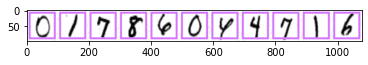

In [4]:
data="01786044716"
df_dict=get_df_dict(en_dir,en_vocab)
plt.imshow(create_number_image(df_dict,data))

In [ ]:
num_samples=1000000
_vocab=en_vocab
_dir=en_dir
lang_dir=create_dir(save_dir,"english")
img_dir=create_dir(lang_dir,"images")
data_csv=os.path.join(lang_dir,"data.csv")
df_dict=get_df_dict(_dir,_vocab)
words=[]
labels=[]
masks=[]
filepaths=[]
max_len=15

for i in tqdm(range(num_samples)):
    try:
        if random_exec(weights=[0.65,0.35]):
            dlen=11
        else:
            if random_exec(weights=[0.65,0.35]):
                dlen=2
            else:
                dlen=random.randint(3,10)
        label="".join([random.choice(_vocab) for _ in range(dlen)])
        #d-w
        words.append(label)

        img=create_number_image(df_dict,label)
        img,mask=correctPadding(img,dim=(64,512),ptype="left")
        #d-m
        masks.append(mask)
        # d-f
        filepath=os.path.join(img_dir,f"{i}.png")
        cv2.imwrite(filepath,img)
        filepaths.append(filepath)
        # d-l
        label=[_vocab.index(c)+1 for c in label]
        for _ in range(max_len-len(label)):
            label.append(0)
        labels.append(label)
    except Exception as e:
        print(e)


df=pd.DataFrame({"filepath":filepaths,"label":labels,"word":words,"mask":masks})
df.to_csv(data_csv,index=False)
df

In [ ]:
num_samples=1000000
_vocab=bn_vocab
_dir=bn_dir
lang_dir=create_dir(save_dir,"bangla")
img_dir=create_dir(lang_dir,"images")
data_csv=os.path.join(lang_dir,"data.csv")
df_dict=get_df_dict(_dir,_vocab)
words=[]
labels=[]
masks=[]
filepaths=[]
max_len=15

for i in tqdm(range(num_samples)):
    try:
        if random_exec(weights=[0.65,0.35]):
            dlen=11
        else:
            if random_exec(weights=[0.65,0.35]):
                dlen=2
            else:
                dlen=random.randint(3,10)
        label="".join([random.choice(_vocab) for _ in range(dlen)])
        #d-w
        words.append(label)

        img=create_number_image(df_dict,label)
        img,mask=correctPadding(img,dim=(64,512),ptype="left")
        #d-m
        masks.append(mask)
        # d-f
        filepath=os.path.join(img_dir,f"{i}.png")
        cv2.imwrite(filepath,img)
        filepaths.append(filepath)
        # d-l
        label=[_vocab.index(c)+1 for c in label]
        for _ in range(max_len-len(label)):
            label.append(0)
        labels.append(label)
    except Exception as e:
        print(e)


df=pd.DataFrame({"filepath":filepaths,"label":labels,"word":words,"mask":masks})
df.to_csv(data_csv,index=False)
df

In [ ]:

import os 
import json
import math
import pandas as pd 
import tensorflow as tf
import numpy as np 
from ast import literal_eval
from tqdm.auto import tqdm
tqdm.pandas()
#---------------------------------------------------------------
# data functions
#---------------------------------------------------------------
cols=["filepath","label","word","mask"]
eval_cols=["label"]
    
# feature fuctions
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _int64_list_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def toTfrecord(df,rnum,rec_path):
    '''
        args:
            df      :   the dataframe that contains the information to store
            rnum    :   record number
            rec_path:   save_path
            mask_dim:   the dimension of the mask
    '''
    tfrecord_name=f'{rnum}.tfrecord'
    tfrecord_path=os.path.join(rec_path,tfrecord_name) 
    with tf.io.TFRecordWriter(tfrecord_path) as writer:    
        
        for idx in range(len(df)):
            # base
            img_path=df.iloc[idx,0]
            # img
            with(open(img_path,'rb')) as fid:
                image_png_bytes=fid.read()
            # feature desc
            data ={ 'image':_bytes_feature(image_png_bytes)}

            for cidx,col in enumerate(cols):
                if col in eval_cols:
                    data[col]=_int64_list_feature(df.iloc[idx,cidx]) 

            
            features=tf.train.Features(feature=data)
            example= tf.train.Example(features=features)
            serialized=example.SerializeToString()
            writer.write(serialized)  

def createRecords(data,save_path,tf_size=10240):
    '''
        creates tf records:
        args:
            data        :   either the csv path or a dataframe
            save_path   :   location to save tfrecords
    '''
    if type(data)==str:
        data=pd.read_csv(data)
        for col in eval_cols:
            data[col]=data[col].progress_apply(lambda x: literal_eval(x))
    
    for idx in tqdm(range(0,len(data),tf_size)):
        df        =   data.iloc[idx:idx+tf_size]  
        rnum      =   idx//tf_size
        toTfrecord(df,rnum,save_path)

    
    

In [ ]:
lang_dir=create_dir(save_dir,"english")
rec_dir=create_dir(lang_dir,"tfrecords")
data=os.path.join(lang_dir,"data.csv")
createRecords(data,rec_dir)

In [ ]:
lang_dir=create_dir(save_dir,"bangla")
rec_dir=create_dir(lang_dir,"tfrecords")
data=os.path.join(lang_dir,"data.csv")
createRecords(data,rec_dir)

In [ ]:
# formulate robust scanner as backup

In [7]:
# classification
bn=os.path.join(save_dir,"bangla","data.csv")
en=os.path.join(save_dir,"english","data.csv")
bn=pd.read_csv(bn)
en=pd.read_csv(en)
bn=bn.sample(frac=1)
bn.reset_index(inplace=True,drop=True)
en=en.sample(frac=1)
en.reset_index(inplace=True,drop=True)
bn=bn[:100000]
en=en[:100000]
df=pd.concat([bn,en],ignore_index=True)
df=df.sample(frac=1)
df.reset_index(inplace=True,drop=True)
df

,filepath,label,word,mask
0,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",30,106
1,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[7, 3, 6, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",6259,256
2,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[9, 1, 3, 3, 8, 2, 9, 1, 0, 0, 0, 0, 0, 0, 0]",৮০২২৭১৮০,0
3,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[8, 6, 4, 4, 8, 5, 9, 4, 6, 8, 8, 0, 0, 0, 0]",75337483577,512
4,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[4, 7, 5, 8, 8, 1, 6, 9, 5, 2, 4, 0, 0, 0, 0]",36477058413,512
...,...,...,...,...
199995,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[4, 8, 8, 7, 3, 1, 3, 1, 1, 8, 10, 0, 0, 0, 0]",37762020079,512
199996,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[3, 5, 8, 8, 10, 6, 10, 5, 7, 10, 4, 0, 0, 0, 0]",২৪৭৭৯৫৯৪৬৯৩,512
199997,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[1, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",০৯,128
199998,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[3, 5, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",২৪৮,192


In [8]:
df=df[["filepath","word","mask"]]
df

,filepath,word,mask
0,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,30,106
1,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,6259,256
2,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,৮০২২৭১৮০,0
3,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,75337483577,512
4,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,36477058413,512
...,...,...,...
199995,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,37762020079,512
199996,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,২৪৭৭৯৫৯৪৬৯৩,512
199997,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,০৯,128
199998,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,২৪৮,192


In [9]:
df.to_csv("data.csv",index=False)

In [11]:
pos_max=40
from coreLib.languages import vocab
from coreLib.processing import processLabels
df.word=df.word.progress_apply(lambda x:str(x))
df=processLabels(df,vocab,pos_max)
# save data
cols=["filepath","mask","label"]
df=df[cols]
df.dropna(inplace=True)


100%|██████████| 200000/200000 [00:00<00:00, 1137333.51it/s]
/home/apsisdev/.local/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
100%|██████████| 200000/200000 [00:00<00:00, 328429.87it/s]
<ipython-input-11-8adcdf983c0f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [12]:
df

,filepath,mask,label
0,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,106,"[292, 19, 16, 292, 293, 293, 293, 293, 293, 29..."
1,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,256,"[292, 22, 18, 21, 25, 292, 293, 293, 293, 293,..."
2,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,0,"[292, 289, 281, 283, 283, 288, 282, 289, 281, ..."
3,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,512,"[292, 23, 21, 19, 19, 23, 20, 24, 19, 21, 23, ..."
4,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,512,"[292, 19, 22, 20, 23, 23, 16, 21, 24, 20, 17, ..."
...,...,...,...
199995,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,512,"[292, 19, 23, 23, 22, 18, 16, 18, 16, 16, 23, ..."
199996,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,512,"[292, 283, 285, 288, 288, 290, 286, 290, 285, ..."
199997,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,128,"[292, 281, 290, 292, 293, 293, 293, 293, 293, ..."
199998,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,192,"[292, 283, 285, 289, 292, 293, 293, 293, 293, ..."


In [17]:
import math
def convertMask(x):
    imask=math.ceil((x/512)*(512//32))
    mask=np.zeros((64//32,512//32))
    mask[:,:imask]=1
    mask=mask.flatten().tolist()
    mask=[int(i) for i in mask]
    return mask


In [21]:
df["mask"]=df["mask"].progress_apply(lambda x: convertMask(x))
df

100%|██████████| 200000/200000 [00:01<00:00, 140404.75it/s]
<ipython-input-21-7b9be600f47a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["mask"]=df["mask"].progress_apply(lambda x: convertMask(x))


,filepath,mask,label
0,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[292, 19, 16, 292, 293, 293, 293, 293, 293, 29..."
1,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[292, 22, 18, 21, 25, 292, 293, 293, 293, 293,..."
2,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[292, 289, 281, 283, 283, 288, 282, 289, 281, ..."
3,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[292, 23, 21, 19, 19, 23, 20, 24, 19, 21, 23, ..."
4,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[292, 19, 22, 20, 23, 23, 16, 21, 24, 20, 17, ..."
...,...,...,...
199995,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[292, 19, 23, 23, 22, 18, 16, 18, 16, 16, 23, ..."
199996,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[292, 283, 285, 288, 288, 290, 286, 290, 285, ..."
199997,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[292, 281, 290, 292, 293, 293, 293, 293, 293, ..."
199998,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[292, 283, 285, 289, 292, 293, 293, 293, 293, ..."


In [22]:
save_dir="/home/apsisdev/ansary/DATASETS/APSIS/CDR/datasets/numbers/tfrecords/"
from coreLib.store import createRecords
createRecords(df,save_dir)

  0%|          | 0/20 [00:00<?, ?it/s]

#LOG     :Creating TFRECORDS No folds:/home/apsisdev/ansary/DATASETS/APSIS/CDR/datasets/numbers/tfrecords/


100%|██████████| 20/20 [01:26<00:00,  4.31s/it]
